### Imports

In [1]:
#%matplotlib widget
from copy import deepcopy
import gym
from dqn2 import dqn, Model, AggregateModel
from v1.utils2 import linear_decay_clip, plot_2d_value_function, test_env
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pickle

### Load MountainCar-v0

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n
lows = env.observation_space.low
highs = env.observation_space.high
print(f'There are {n_features} features & {n_actions} actions')
print(f'Car Position ranges from {lows[0]} to {highs[0]}')
print(f'Car Velocty ranges from {lows[1]} to {highs[1]}')

There are 2 features & 3 actions
Car Position ranges from -1.2000000476837158 to 0.6000000238418579
Car Velocty ranges from -0.07000000029802322 to 0.07000000029802322


### Naive Q-Learning

In [4]:
model = AggregateModel(lows, highs, 10, n_actions, 0.1)

In [25]:
model, history = dqn(
    env=env, gamma=1, epsilon=linear_decay_clip(0, 0, 1),
    model=model, capacity=1, warmup_steps=0, train_steps=50000,
    update_steps=1, batch_size=1)

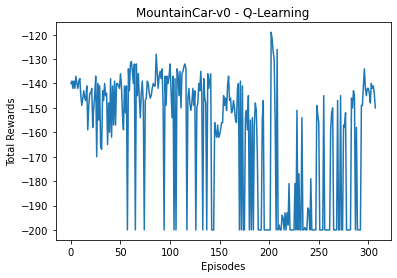

In [26]:
%matplotlib inline
plt.plot(range(len(history['eps_rewards'])), history['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

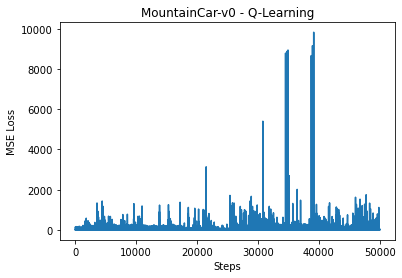

In [27]:
%matplotlib inline
plt.plot(range(len(history['losses'])), history['losses'])
plt.xlabel('Steps')
plt.ylabel('MSE Loss')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

In [29]:
%matplotlib qt
plot_2d_value_function(
    lambda state: np.amax(model.q_values(state)),
    lows, highs, intervals=20, invert_z=True,
    zlabel='State Value', xlabel='Position', ylabel='Velocity')

In [23]:
test_env(env, action_func=lambda state: np.argmax(model.q_values(state)))

137


### DQN

In [28]:
class SampleModel(Model, nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 16)
        self.fc2 = nn.Linear(16, n_actions)
        self.opt = optim.Adam(self.parameters(), lr=0.01)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    def q_values(self, state):
        x = torch.tensor(state, dtype=torch.float)
        with torch.no_grad():
            q_values = self.forward(x)
        return q_values.numpy()
    def update(self, states, actions, targets):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long)
        targets = torch.tensor(targets, dtype=torch.float)
        ds = TensorDataset(states, actions, targets)
        dl = DataLoader(ds, batch_size=1)
        acc_loss = 0
        for states, actions, targets in dl:
            q_values_pred = self.forward(states)
            q_values_true = q_values_pred.detach().clone()
            q_values_true[range(len(states)), actions] = targets
            loss = F.mse_loss(q_values_pred, q_values_true)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            acc_loss += loss.item() * len(states)
        return acc_loss / len(ds)
    def copy(self):
        return deepcopy(self)

In [29]:
model3 = SampleModel()
model3, history3 = dqn(
    env=env, gamma=1, epsilon=linear_decay_clip(0.1, 0.1, 10000),
    model=model3, capacity=4000, warmup_steps=2000, train_steps=10000,
    update_steps=2000, batch_size=32)

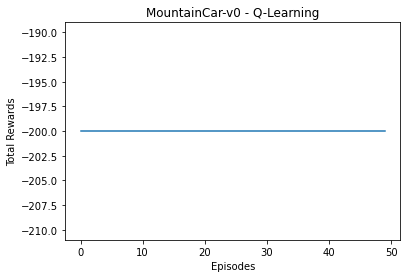

In [30]:
%matplotlib inline
plt.plot(range(len(history3['eps_rewards'])), history3['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

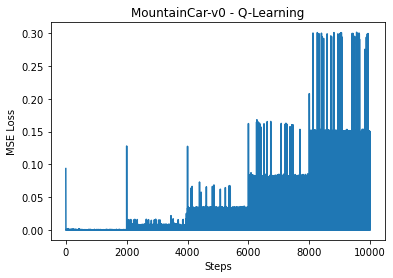

In [31]:
%matplotlib inline
plt.plot(range(len(history3['losses'])), history3['losses'])
plt.xlabel('Steps')
plt.ylabel('MSE Loss')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

In [32]:
%matplotlib qt
plot_2d_value_function(
    lambda state: np.amax(model3.q_values(state)),
    lows, highs, intervals=20, invert_z=True)

In [33]:
test_env(env, action_func=lambda state: np.argmax(model3.q_values(state)))

199


### DQN 2

In [4]:
class SampleModel(Model, nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, n_actions)
        self.opt = optim.Adam(self.parameters(), lr=0.001)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def q_values(self, state):
        x = torch.tensor(state, dtype=torch.float)
        with torch.no_grad():
            q_values = self.forward(x)
        return q_values.numpy()
    def update(self, states, actions, targets):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long)
        targets = torch.tensor(targets, dtype=torch.float)
        ds = TensorDataset(states, actions, targets)
        dl = DataLoader(ds, batch_size=len(ds))
        acc_loss = 0
        for states, actions, targets in dl:
            q_values_pred = self.forward(states)
            q_values_true = q_values_pred.detach().clone()
            q_values_true[range(len(states)), actions] = targets
            loss = F.mse_loss(q_values_pred, q_values_true)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            acc_loss += loss.item() * len(states)
        return acc_loss / len(ds)
    def copy(self):
        return deepcopy(self)

In [ ]:
model2 = SampleModel()
model2, history2 = dqn(
    env=env, gamma=0.99, epsilon=linear_decay_clip(0.01, 0.01, 1),
    model=model2, capacity=50000, warmup_steps=2000, train_steps=200000,
    update_steps=1000, batch_size=64)

In [5]:
model2 = SampleModel()
model2.load_state_dict(torch.load('model2'))
with open('history2.pickle', 'rb') as file:
    history2 = pickle.load(file)

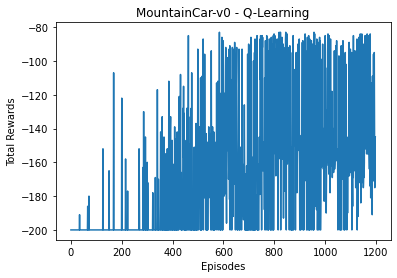

In [6]:
%matplotlib inline
plt.plot(range(len(history2['eps_rewards'])), history2['eps_rewards'])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

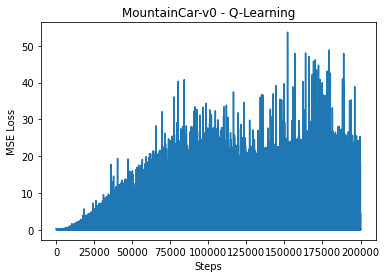

In [7]:
%matplotlib inline
plt.plot(range(len(history2['losses'])), history2['losses'])
plt.xlabel('Steps')
plt.ylabel('MSE Loss')
plt.title('MountainCar-v0 - Q-Learning')
plt.show()

In [6]:
%matplotlib qt
plot_2d_value_function(
    lambda state: np.amax(model2.q_values(state)),
    lows, highs, intervals=100, invert_z=True)

In [11]:
import v2.plot as Plot
Plot.value_function_2d(
    lambda state: max(model2.q_values(state)),
    lows, highs, intervals=100,
    zlabel='State Values',
    xlabel='Position', ylabel='Velocity',
    title='MountainCar-v0', invert_z=True)

In [13]:
Plot.value_function_2d(
    lambda state: max(model2.q_values(state)),
    lows, highs, intervals=100,
    zlabel='State Value Function',
    xlabel='Position', ylabel='Velocity',
    title='MountainCar-v0 - State Values', heatmap=True)

In [11]:
test_env(env, action_func=lambda state: np.argmax(model2.q_values(state)))

150


In [27]:
torch.save(model2.state_dict(), 'model2')

In [35]:
with open('history2.pickle', 'wb') as file:
    pickle.dump(history2, file)